In [1]:
import torch
import drlqap.nn
import drlqap.qap
import drlqap.simplesolver
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
n = 8
w = 8

In [4]:
with open("../qapdata/testgraph.dat", "r") as f:
    qap = drlqap.qap.GraphAssignmentProblem.from_qaplib_string(f.read())

optimal_value, optimal_assignment = drlqap.simplesolver.solve_qap_backtracking(qap)
optimal_matrix = torch.eye(qap.size)[optimal_assignment]    

input_matrix1 = torch.rand((n, w))
input_matrix2 = torch.rand((n, w))
concat_input = drlqap.nn.cartesian_product_matrix(input_matrix1, input_matrix2)

tensor(0.1250)


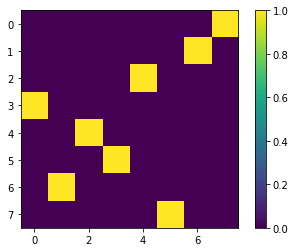

In [5]:
#output_matrix = torch.rand((n, w))
output_matrix = optimal_matrix
print(output_matrix.mean())
plt.imshow(output_matrix)
plt.colorbar()

In [6]:
nets = {
    "3 Hidden": drlqap.nn.FullyConnectedLinearOut(w*2, w, 1, 3, activation=torch.nn.LeakyReLU),
    "3 Hidden LN": drlqap.nn.FullyConnectedLinearOut(w*2, w, 1, 3, activation=torch.nn.LeakyReLU, layer_norm=True),
    "Shallow": drlqap.nn.FullyConnectedLinearOut(w*2, w, 1, 0, activation=torch.nn.LeakyReLU),
    "1 Hidden": drlqap.nn.FullyConnectedLinearOut(w*2, w, 1, 1, activation=torch.nn.LeakyReLU),
}

In [7]:
def train(net, epochs, *inputs, lr=0.01):
    optimizer = torch.optim.Adam(params=net.parameters(), lr=lr)   
    losses = []
    target = output_matrix
    for i in range(epochs):
        optimizer.zero_grad(set_to_none=True)
        net_output = net(*inputs)
        loss = torch.nn.functional.mse_loss(net_output.flatten(), target.flatten())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [8]:
losses = {}
for name, net in nets.items():
    losses[name] = train(net, 1000, concat_input, lr=0.01)
    print(f"{name} finished")

3 Hidden finished
3 Hidden LN finished
Shallow finished
1 Hidden finished


3 Hidden 4.632775471691275e-06
3 Hidden LN 4.065511348017026e-06
Shallow 0.020087454468011856
1 Hidden 0.06406617164611816


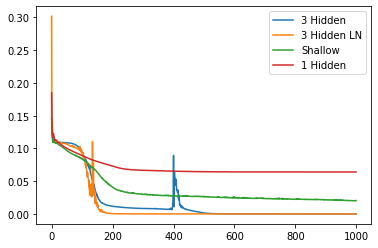

In [9]:
for name, loss in losses.items():
    print(name, loss[-1])
    plt.plot(loss, label=name)
plt.legend()
plt.show()

3 Hidden


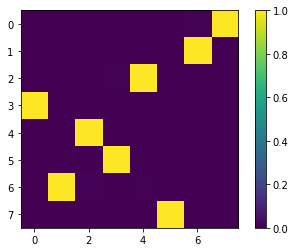

3 Hidden LN


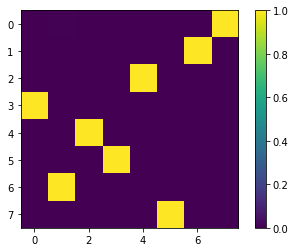

Shallow


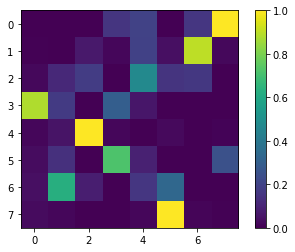

1 Hidden


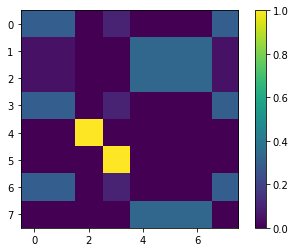

In [10]:
with torch.no_grad():
    for name, net in nets.items():
        print(name)
        plt.imshow(net(concat_input), vmin=0, vmax=1)
        plt.colorbar()
        plt.show()

Target


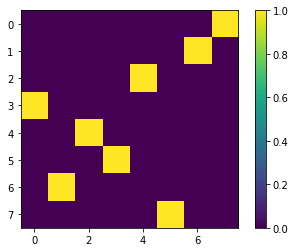

Mean


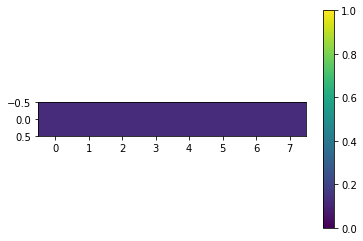

In [11]:
output_mean = torch.mean(output_matrix, dim=0, keepdims=True)
print("Target")
plt.imshow(output_matrix, vmin=0, vmax=1)
plt.colorbar()
plt.show()
print("Mean")
plt.imshow(output_mean, vmin=0, vmax=1)
plt.colorbar()
plt.show()